Create two pipelines:
both on a regular .py file, one with all files contain lat/long data and one with geo data. eac shloud add for every one of the dataframes two columns- one with the street geometry and one with its index.
1. lat/long files: collisions, violations, historic violations,
2. geo data: humps, speed limits, intersections upgrade, turn traffic calming, leading pedestrian signals, points of intrests
3. needs further thinking: traffic lights and signals, traffic volume counts (understand how to inpute location from segment ID)
4. fil na values in collisions
5. look at some other datas that we might had forgot
6. concat all dataframes via street index
7. aggregate by time (year? month?) maybe we should also concat by location (block?)
8. how to run the python programs for 20 hours

Tom: 1, 8, 4, 5

Max: 2, 3, 4, 5

Next: 6, 7


1. Remove unnecessary columns
2. Aggregate by **month** (but write in generic)
3. Max: check speed limits- large amount of rows
4. Consider concat by location

In [ ]:
import numpy as np
import pandas as pd
!pip install geopandas
import geopandas as gpd
import folium
from shapely.geometry import Point
from functools import partial
from geopy.geocoders import Nominatim
!pip install opencage
import opencage.geocoder
from shapely import wkt
import warnings

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 22.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.4/16.4 MB 90.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 83.9 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [1]:
from google.colab import drive
drive.mount('/content/drive')
TOM_FILES_DIR = "/content/drive/My Drive/Colab Notebooks/data science- transportation research/"
MAX_FILES_DIR = "/content/drive/My Drive/data science- transportation research/"
FILES_DIR = TOM_FILES_DIR

MessageError: ignored

In [ ]:
collisions_df = pd.read_csv(f"{FILES_DIR}Motor_Vehicle_Collisions_-_Crashes.csv")

<ipython-input-3-05fd5104fd22>:1: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  collisions_df = pd.read_csv(f"{FILES_DIR}Motor_Vehicle_Collisions_-_Crashes.csv")


In [ ]:
collisions_df_not_na = collisions_df[(collisions_df["LONGITUDE"].notna()) & (collisions_df["LATITUDE"].notna())]
collisions_df_is_na = collisions_df[(collisions_df["LONGITUDE"].isna()) | (collisions_df["LATITUDE"].isna())]
collisions_df_not_na

,CRASH DATE,CRASH TIME,BOROUGH,ZIP CODE,LATITUDE,LONGITUDE,LOCATION,ON STREET NAME,CROSS STREET NAME,OFF STREET NAME,...,CONTRIBUTING FACTOR VEHICLE 2,CONTRIBUTING FACTOR VEHICLE 3,CONTRIBUTING FACTOR VEHICLE 4,CONTRIBUTING FACTOR VEHICLE 5,COLLISION_ID,VEHICLE TYPE CODE 1,VEHICLE TYPE CODE 2,VEHICLE TYPE CODE 3,VEHICLE TYPE CODE 4,VEHICLE TYPE CODE 5
3,09/11/2021,9:35,BROOKLYN,11208.0,40.667202,-73.866500,"(40.667202, -73.8665)",NaN,NaN,1211 LORING AVENUE,...,NaN,NaN,NaN,NaN,4456314,Sedan,NaN,NaN,NaN,NaN
4,12/14/2021,8:13,BROOKLYN,11233.0,40.683304,-73.917274,"(40.683304, -73.917274)",SARATOGA AVENUE,DECATUR STREET,NaN,...,NaN,NaN,NaN,NaN,4486609,NaN,NaN,NaN,NaN,NaN
6,12/14/2021,17:05,NaN,NaN,40.709183,-73.956825,"(40.709183, -73.956825)",BROOKLYN QUEENS EXPRESSWAY,NaN,NaN,...,Unspecified,NaN,NaN,NaN,4486555,Sedan,Tractor Truck Diesel,NaN,NaN,NaN
7,12/14/2021,8:17,BRONX,10475.0,40.868160,-73.831480,"(40.86816, -73.83148)",NaN,NaN,344 BAYCHESTER AVENUE,...,Unspecified,NaN,NaN,NaN,4486660,Sedan,Sedan,NaN,NaN,NaN
8,12/14/2021,21:10,BROOKLYN,11207.0,40.671720,-73.897100,"(40.67172, -73.8971)",NaN,NaN,2047 PITKIN AVENUE,...,Unspecified,NaN,NaN,NaN,4487074,Sedan,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1982061,04/04/2023,22:25,QUEENS,11377.0,40.749700,-73.902565,"(40.7497, -73.902565)",60 STREET,37 AVENUE,NaN,...,Unspecified,NaN,NaN,NaN,4618311,Sedan,Sedan,NaN,NaN,NaN
1982062,04/04/2023,21:40,QUEENS,11356.0,40.790695,-73.845505,"(40.790695, -73.845505)",NaN,NaN,7-07 COLLEGE POINT BOULEVARD,...,NaN,NaN,NaN,NaN,4618210,Sedan,NaN,NaN,NaN,NaN
1982064,04/04/2023,20:10,NaN,NaN,40.672382,-73.785740,"(40.672382, -73.78574)",BAISLEY BOULEVARD,NaN,NaN,...,Unspecified,NaN,NaN,NaN,4618688,Station Wagon/Sport Utility Vehicle,Sedan,NaN,NaN,NaN
1982065,03/29/2023,11:05,MANHATTAN,10011.0,40.735520,-73.993990,"(40.73552, -73.99399)",NaN,NaN,74 5 AVENUE,...,Unspecified,NaN,NaN,NaN,4618702,E-Bike,Sedan,NaN,NaN,NaN


In [ ]:
# fiona.drvsupport.supported_drivers['kml'] = 'rw' # enable KML support which is disabled by default
streets_df = gpd.read_file(f"{FILES_DIR}NYC Street Centerline (CSCL).geojson")

In [ ]:
streets_df

,rw_type,l_low_hn,pre_direct,st_width,r_zip,r_low_hn,bike_lane,post_type,r_blkfc_id,bike_trafd,...,snow_pri,borocode,trafdir,pre_modifi,st_label,physicalid,st_name,created,l_high_hn,geometry
0,1,50,NaN,42.0,10280,51,NaN,PL,1222601917,NaN,...,C,1,TW,NaN,BATTERY PL,3,BATTERY,2007-11-29,64,"MULTILINESTRING ((-74.01793 40.70617, -74.0178..."
1,1,66,NaN,42.0,10280,65,NaN,PL,1222604562,NaN,...,C,1,TW,NaN,BATTERY PL,5,BATTERY,2007-11-29,82,"MULTILINESTRING ((-74.01757 40.70684, -74.0171..."
2,1,84,NaN,42.0,10280,83,NaN,PL,1222600933,NaN,...,C,1,TW,NaN,BATTERY PL,6,BATTERY,2007-11-29,98,"MULTILINESTRING ((-74.01712 40.70746, -74.0166..."
3,1,NaN,NaN,42.0,10280,NaN,NaN,PL,1222600931,NaN,...,C,1,TW,NaN,BATTERY PL,8,BATTERY,2007-11-29,NaN,"MULTILINESTRING ((-74.01694 40.70481, -74.0170..."
4,1,NaN,NaN,24.0,10004,NaN,NaN,PL,212262395,NaN,...,C,1,TF,NaN,BATTERY PL,14,BATTERY,2011-04-22,NaN,"MULTILINESTRING ((-74.01429 40.70455, -74.0143..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
121110,1,NaN,NaN,28.0,11694,NaN,NaN,ST,12261403,NaN,...,S,4,NV,NaN,BCH 144 ST,199603,144,2023-03-27,NaN,"MULTILINESTRING ((-73.86273 40.57582, -73.8627..."
121111,9,NaN,NaN,22.0,10002,NaN,NaN,ST,212260114,NaN,...,V,1,FT,NaN,CHRYSTIE ST,199605,CHRYSTIE,2007-11-29,NaN,"MULTILINESTRING ((-73.99489 40.71571, -73.9949..."
121112,1,NaN,NaN,32.0,10002,NaN,NaN,ST,212261868,NaN,...,V,1,FT,NaN,CANAL ST,199606,CANAL,2007-11-29,NaN,"MULTILINESTRING ((-73.99527 40.71558, -73.9953..."
121113,1,NaN,NaN,26.0,10000,NaN,1,NaN,1322607903,TF,...,S,1,TF,NaN,CENTRAL PARK ENTRANCE POWELL BLVD,199610,CENTRAL PARK ENTRANCE POWELL BLVD,2007-11-29,NaN,"MULTILINESTRING ((-73.95595 40.79928, -73.9557..."


In [ ]:
(streets_df.length).argmin()

<ipython-input-11-37e05663a969>:1: UserWarning: Geometry is in a geographic CRS. Results from 'length' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  (streets_df.length).argmin()


119559

In [ ]:
traffic_volume_df = pd.read_csv(f"{FILES_DIR}Automated_Traffic_Volume_Counts.csv")

In [ ]:
traffic_volume_df

,RequestID,Boro,Yr,M,D,HH,MM,Vol,SegmentID,WktGeom,street,fromSt,toSt,Direction
0,1100,Staten Island,2011,10,14,10,45,102,103882,POINT (963246 173171.4),BAY ST,RICHMOND TERR,STUYVESANT PL,SB
1,1100,Staten Island,2011,10,14,11,0,110,103882,POINT (963246 173171.4),BAY ST,RICHMOND TERR,STUYVESANT PL,SB
2,1100,Staten Island,2011,10,14,11,15,101,103882,POINT (963246 173171.4),BAY ST,RICHMOND TERR,STUYVESANT PL,SB
3,1100,Staten Island,2011,10,14,11,30,112,103882,POINT (963246 173171.4),BAY ST,RICHMOND TERR,STUYVESANT PL,SB
4,1100,Staten Island,2011,10,14,11,45,94,103882,POINT (963246 173171.4),BAY ST,RICHMOND TERR,STUYVESANT PL,SB
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27414476,31054,Queens,2019,10,20,22,45,5,49507,POINT (1018436.0690197587 196329.9638902961),73 PLACE,Central Avenue,Dead end,SB
27414477,31054,Queens,2019,10,20,23,0,7,49507,POINT (1018436.0690197587 196329.9638902961),73 PLACE,Central Avenue,Dead end,SB
27414478,31054,Queens,2019,10,20,23,15,4,49507,POINT (1018436.0690197587 196329.9638902961),73 PLACE,Central Avenue,Dead end,SB
27414479,31054,Queens,2019,10,20,23,30,5,49507,POINT (1018436.0690197587 196329.9638902961),73 PLACE,Central Avenue,Dead end,SB


Error: Runtime no longer has a reference to this dataframe, please re-run this cell and try again.
Error: Runtime no longer has a reference to this dataframe, please re-run this cell and try again.
Error: Runtime no longer has a reference to this dataframe, please re-run this cell and try again.
Error: Runtime no longer has a reference to this dataframe, please re-run this cell and try again.


In [ ]:
small_traffic_df = traffic_volume_df.iloc[:100]
small_traffic_df['geometry'] = small_traffic_df.WktGeom.apply(wkt.loads)
small_traffic_df.drop('WktGeom', axis=1, inplace=True) #Drop WKT column

# Geopandas GeoDataFrame
gdf = gpd.GeoDataFrame(small_traffic_df, geometry='geometry')
gdf
#Export to shapefile
#gdf.to_file('traffic_volume.geojson')

<ipython-input-6-446f156173b1>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_traffic_df['geometry'] = small_traffic_df.WktGeom.apply(wkt.loads)
<ipython-input-6-446f156173b1>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_traffic_df.drop('WktGeom', axis=1, inplace=True) #Drop WKT column


,RequestID,Boro,Yr,M,D,HH,MM,Vol,SegmentID,street,fromSt,toSt,Direction,geometry
0,1100,Staten Island,2011,10,14,10,45,102,103882,BAY ST,RICHMOND TERR,STUYVESANT PL,SB,POINT (963246.000 173171.400)
1,1100,Staten Island,2011,10,14,11,0,110,103882,BAY ST,RICHMOND TERR,STUYVESANT PL,SB,POINT (963246.000 173171.400)
2,1100,Staten Island,2011,10,14,11,15,101,103882,BAY ST,RICHMOND TERR,STUYVESANT PL,SB,POINT (963246.000 173171.400)
3,1100,Staten Island,2011,10,14,11,30,112,103882,BAY ST,RICHMOND TERR,STUYVESANT PL,SB,POINT (963246.000 173171.400)
4,1100,Staten Island,2011,10,14,11,45,94,103882,BAY ST,RICHMOND TERR,STUYVESANT PL,SB,POINT (963246.000 173171.400)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,1100,Staten Island,2011,10,15,10,30,97,103882,BAY ST,RICHMOND TERR,STUYVESANT PL,SB,POINT (963246.000 173171.400)
96,1100,Staten Island,2011,10,15,10,45,138,103882,BAY ST,RICHMOND TERR,STUYVESANT PL,SB,POINT (963246.000 173171.400)
97,1100,Staten Island,2011,10,15,11,0,100,103882,BAY ST,RICHMOND TERR,STUYVESANT PL,SB,POINT (963246.000 173171.400)
98,1100,Staten Island,2011,10,15,11,15,121,103882,BAY ST,RICHMOND TERR,STUYVESANT PL,SB,POINT (963246.000 173171.400)


In [ ]:
from shapely.wkt import loads

df = pd.read_csv(f"{FILES_DIR}mapping_segmentid_to_geometry.csv")
small_df = df.iloc[::10000]
small_df['geometry'] = small_df['geometry'].apply(loads)
geometry = gpd.GeoSeries(small_df['geometry'])
gdf = gpd.GeoDataFrame(small_df, geometry=geometry)

<ipython-input-15-4c7393524fe6>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['geometry'] = small_df['geometry'].apply(loads)


In [ ]:
print(df["geometry"].iloc[0])

MULTILINESTRING ((1010964.4469787776 241812.26140345633, 1011265.4949930757 241554.9471912384))


In [ ]:
m = folium.Map(location=[241812.26140345633,1010964.4469787776], zoom_start=12)
for i in range(20):
    # col1 = Point(small_collisions[["LONGITUDE", "LATITUDE"]].iloc[i:i + 1, ])
    folium.GeoJson(gdf["geometry"].iloc[i]).add_to(m)
    # folium.GeoJson(col1).add_to(m)
# folium.GeoJson(streets_df["geometry"].iloc[176]).add_to(m)

m

In [ ]:
print(streets_df["geometry"].iloc[97833])

MULTILINESTRING ((-73.70169386961977 40.752536854041495, -73.7016334589261 40.75249332868778, -73.70162212271006 40.75242551789292))


In [ ]:
m = folium.Map(location=[40.7831, -73.9712], zoom_start=12)
for i in range(97833,97834):
    # col1 = Point(small_collisions[["LONGITUDE", "LATITUDE"]].iloc[i:i + 1, ])
    folium.GeoJson(streets_df["geometry"].iloc[i]).add_to(m)
    # folium.GeoJson(col1).add_to(m)
# folium.GeoJson(streets_df["geometry"].iloc[176]).add_to(m)

m

In [ ]:
df = gpd.read_file(f"{FILES_DIR}VZV_Street Improvement Projects (SIPs) intersections.geojson")
df

,x,pjct_name,y,long,end_date,sip_year,lat,geometry
0,0.0,Boston Rd and Allerton Ave,0.0,-73.8625105004,2018-08-29,2018,40.8654771442,"MULTIPOINT (-73.86258 40.86537, -73.86258 40.8..."
1,0.0,7th Ave and 55th St - RC,0.0,-74.0088248189,2022-12-28,2022,40.6396446304,MULTIPOINT (-74.00882 40.63964)
2,0.0,Vanderbilt Ave at E 2nd St and E 3rd St,0.0,-73.9795541881,2018-12-19,2018,40.6522055057,"MULTIPOINT (-73.97999 40.65203, -73.97911 40.6..."
3,0.0,East New York Ave at Atlantic Ave,0.0,-73.9030249495,2012-11-15,2012,40.6756414805,"MULTIPOINT (-73.90347 40.67574, -73.90258 40.6..."
4,0.0,Riverside Dr and W135th St,0.0,-73.9575233863,2021-07-29,2021,40.821143383,MULTIPOINT (-73.95752 40.82114)
...,...,...,...,...,...,...,...,...
287,0.0,Kings Highway and E 34 / E 35 Street,0.0,-73.9413092045,2017-06-09,2017,40.6199029269,"MULTIPOINT (-73.94183 40.61945, -73.94179 40.6..."
288,0.0,4th Avenue,0.0,-73.9787692803,2011-12-06,2011,40.6837703217,"MULTIPOINT (-73.97884 40.68380, -73.97876 40.6..."
289,0.0,White Plains Rd and Arnow Ave,0.0,-73.8672755677,2021-01-12,2020,40.8678902373,MULTIPOINT (-73.86728 40.86789)
290,0.0,W 259 St & Netherland Ave (EC),0.0,-73.9045939128,2017-09-29,2017,40.9069380396,"MULTIPOINT (-73.90509 40.90701, -73.90410 40.9..."


In [ ]:
small_collisions = collisions_df_not_na.iloc[:100]

In [ ]:
def add_columns_non_geo(df, streets_df):
    streets_buffered_df = streets_df.buffer(0.00015)
    streets_df = streets_df.reset_index()

    def get_closest_street(sample):
        point = Point(sample[["LONGITUDE", "LATITUDE"]])
        df_streets_filtered = streets_df[streets_buffered_df.contains(point)]
        if df_streets_filtered.shape[0] == 0:
            street_index = streets_df.distance(point).argmin()
            return streets_df.iloc[street_index]["geometry"], street_index

        street_filtered_index = df_streets_filtered.distance(point).argmin()
        street_index = df_streets_filtered.iloc[street_filtered_index]["index"]
        return streets_df.iloc[street_index]["geometry"], street_index

    df[['STREET', 'ST_INDEX']] = df.apply(get_closest_street, axis=1, result_type='expand')
    return df

In [ ]:
small_collisions = add_columns_non_geo(small_collisions, streets_df)

In [ ]:
m = folium.Map(location=[40.7831, -73.9712], zoom_start=12)
for i in range(100):
    col1 = Point(small_collisions[["LONGITUDE", "LATITUDE"]].iloc[i:i + 1, ])
    folium.GeoJson(small_collisions["STREET"].iloc[i]).add_to(m)
    folium.GeoJson(col1).add_to(m)
m

In [ ]:
small_data = df_col_not_na.iloc[:1000]

In [ ]:
df_streets_buffered = streets_df.buffer(0.00015)
def get_closest_street(sample):
  point = Point(sample[["LONGITUDE","LATITUDE"]])
  df_streets_filtered = streets_df[df_streets_buffered.contains(point)]
  if df_streets_filtered.shape[0] == 0:
    return streets_df.iloc[streets_df.distance(point).argmin()]["geometry"]
  return df_streets_filtered.iloc[df_streets_filtered.distance(point).argmin()]["geometry"]

<ipython-input-12-9b442c2bc965>:1: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  df_streets_buffered = streets_df.buffer(0.00015)


In [ ]:
df_col_not_na['STREET'] = df_col_not_na.apply(get_closest_street, axis=1)

In [ ]:
df_col_is_na["STREET"] = None
merged_df_col = pd.concat([df_col_not_na, df_col_is_na], axis=0)
merged_df_col.to_csv(f"{FILES_DIR}Collisions_with_streets.csv")

In [ ]:
df_speed_humps = gpd.read_file(f"{FILES_DIR}VZV_Speed Humps.geojson")
# df_speed_limits = gpd.read_file(f"{FILES_DIR}VZV_Speed Limits.geojson")
# df_leading_ped = gpd.read_file(f"{FILES_DIR}VZV_Leading Pedestrian Interval Signals.geojson")
# df_street_imporvements = gpd.read_file(f"{FILES_DIR}VZV_Street Improvement Projects (SIPs) intersections.geojson")
# df_turn_traffic = gpd.read_file(f"{FILES_DIR}NYC Street Centerline (CSCL).geojson")
# df_points_of_interest = gpd.read_file(f"{FILES_DIR}VZV_Turn Traffic Calming.geojson")

In [ ]:
np.sum(df_streets.geom_almost_equals(df_speed_humps.iloc[175]["geometry"], decimal=6))
# np.sum(df_speed_humps.iloc[0]["geometry"].geom_almost_equals(df_streets, decimal=10))

1

In [ ]:
m = folium.Map(location=[40.7831, -73.9712], zoom_start=12)
folium.GeoJson(df_streets[df_streets.geom_almost_equals(df_speed_humps.iloc[0]["geometry"], decimal=1)]["geometry"]).add_to(m)
folium.GeoJson(df_speed_humps.iloc[:1]["geometry"].buffer(0.00015)).add_to(m)
m

<ipython-input-28-f27483d1fae4>:3: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  folium.GeoJson(df_speed_humps.iloc[:1]["geometry"].buffer(0.00015)).add_to(m)


In [ ]:
m = folium.Map(location=[40.7831, -73.9712], zoom_start=12)
folium.GeoJson(df_speed_humps.iloc[:100]["geometry"]).add_to(m)
# folium.GeoJson(small_data["geometry"].buffer(0.00015)).add_to(m)
m

In [ ]:
def check_multilinestring_overlap(df: pd.DataFrame, gdf: gpd.GeoDataFrame) -> pd.Series:
    """
    Checks if each MULTILINESTRING in df['street'] overlaps with any MULTILINESTRING in gdf['geometry'].

    Parameters:
    - df: a pandas DataFrame with a column 'street' containing MULTILINESTRINGs.
    - gdf: a geopandas GeoDataFrame with a column 'geometry' containing MULTILINESTRINGs.

    Returns:
    - A pandas Series of boolean values indicating if each row in df['street'] overlaps with any row in gdf['geometry'].
    """
    df_geoms = df['STREET']
    gdf_geoms = gdf['geometry']
    overlaps = df_geoms.apply(lambda geom: gdf_geoms.overlaps(geom).any())
    return overlaps

In [ ]:
df_col['added_speed_hump'] = check_multilinestring_overlap(df_col,df_speed_humps)
# TODO each segment and its road speed. need implelemnt differently.
df_col['changed_speed_limit'] = check_multilinestring_overlap(df_col,df_speed_limits)
df_col['added_leading_pedestrian'] = check_multilinestring_overlap(df_col,df_leading_ped)
df_col['added_street_imporvements'] = check_multilinestring_overlap(df_col,df_street_imporvements)
df_col['added_turn_traffic'] = check_multilinestring_overlap(df_col,df_turn_traffic)
df_col['contains_points_of_interest'] = check_multilinestring_overlap(df_col,df_points_of_interest)

In [ ]:
streets_buffer = df_streets.buffer(0.00015)
humps_buffer = df_speed_humps.buffer(0.00015)

In [ ]:
inter = streets_buffer.intersection(humps_buffer.iloc[0])
uni = streets_buffer.union(humps_buffer.iloc[0])
(inter.area/uni.area).argmax()

/usr/local/lib/python3.9/dist-packages/shapely/set_operations.py:133: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)
<ipython-input-59-74730294825f>:3: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  (inter.area/uni.area).argmax()


60635

In [ ]:
m = folium.Map(location=[40.7831, -73.9712], zoom_start=12)
streets_buffer = df_streets.buffer(0.00015)
humps_buffer = df_speed_humps.buffer(0.00015)

<ipython-input-61-8c292cfc402b>:2: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  streets_buffer = df_streets.buffer(0.00015)
<ipython-input-61-8c292cfc402b>:3: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  humps_buffer = df_speed_humps.buffer(0.00015)


In [ ]:
for i in range(0,1000):
  hump = humps_buffer.iloc[i]
  df_streets_filtered = streets_buffer[streets_buffer.intersects(humps_buffer.iloc[i])]
  inter = df_streets_filtered.intersection(humps_buffer.iloc[i])
  uni = df_streets_filtered.union(humps_buffer.iloc[i])
  iou = (inter.area/uni.area).argmax()
  folium.GeoJson(df_streets_filtered.iloc[iou:iou+1]).add_to(m)
  folium.GeoJson(df_speed_humps.iloc[i]["geometry"]).add_to(m)
m

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
for i in range(0,1000,100):
  hump = humps_buffer.iloc[i]
  # df_streets_filtered = df_streets[df_streets_buffered.contains(col1)]
  inter = streets_buffer.intersection(humps_buffer.iloc[i])
  uni = streets_buffer.union(humps_buffer.iloc[i])
  iou = (inter.area/uni.area).argmax()
  folium.GeoJson(df_streets["geometry"].iloc[iou:iou+1]).add_to(m)
  folium.GeoJson(humps_buffer.iloc[i]).add_to(m)
m

/usr/local/lib/python3.9/dist-packages/shapely/set_operations.py:133: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)
<ipython-input-63-9d7185ecd71a>:6: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  iou = (inter.area/uni.area).argmax()
/usr/local/lib/python3.9/dist-packages/shapely/set_operations.py:133: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)
<ipython-input-63-9d7185ecd71a>:6: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  iou = (inter.area/uni.area).argmax()
/usr/local/lib/python3.9/dist-packages/shapely/set_operations.py:133: RuntimeWarning: invalid value encountered in intersection
  return lib.intersect

# Random code

In [ ]:
m = folium.Map(location=[40.7831, -73.9712], zoom_start=12)
folium.GeoJson(df_streets[df_streets.intersects(df_speed_humps.iloc[0]["geometry"].buffer(0.00015))]["geometry"]).add_to(m)
# folium.GeoJson(df_speed_humps.iloc[:1]["geometry"].buffer(0.00015)).add_to(m)
m

In [ ]:
m = folium.Map(location=[40.7831, -73.9712], zoom_start=12)
df_streets_buffered = df_streets.buffer(0.00015)
for i in range(1):
  col1 = Point(df_col_not_na[["LONGITUDE","LATITUDE"]].iloc[i:i+1,])
  df_streets_filtered = df_streets[df_streets_buffered.contains(col1)]
  folium.GeoJson(df_streets_filtered["geometry"].iloc[df_streets_filtered.distance(col1).argmin():df_streets_filtered.distance(col1).argmin()+1]).add_to(m)
  folium.GeoJson(col1).add_to(m)
m

<ipython-input-41-f904e116c74e>:2: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  df_streets_buffered = df_streets.buffer(0.00015)
<ipython-input-41-f904e116c74e>:6: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  folium.GeoJson(df_streets_filtered["geometry"].iloc[df_streets_filtered.distance(col1).argmin():df_streets_filtered.distance(col1).argmin()+1]).add_to(m)


In [ ]:
df_na_loc = df[(df["LONGITUDE"].isna() | df["LATITUDE"].isna())&(df["ON STREET NAME"].notna() & df["CROSS STREET NAME"].notna())]
df_na_loc

,CRASH DATE,CRASH TIME,BOROUGH,ZIP CODE,LATITUDE,LONGITUDE,LOCATION,ON STREET NAME,CROSS STREET NAME,OFF STREET NAME,...,CONTRIBUTING FACTOR VEHICLE 2,CONTRIBUTING FACTOR VEHICLE 3,CONTRIBUTING FACTOR VEHICLE 4,CONTRIBUTING FACTOR VEHICLE 5,COLLISION_ID,VEHICLE TYPE CODE 1,VEHICLE TYPE CODE 2,VEHICLE TYPE CODE 3,VEHICLE TYPE CODE 4,VEHICLE TYPE CODE 5
0,09/11/2021,2:39,NaN,NaN,NaN,NaN,NaN,WHITESTONE EXPRESSWAY,20 AVENUE,NaN,...,Unspecified,NaN,NaN,NaN,4455765,Sedan,Sedan,NaN,NaN,NaN
12,12/14/2021,8:30,NaN,NaN,NaN,NaN,NaN,broadway,west 80 street -west 81 street,NaN,...,Unspecified,NaN,NaN,NaN,4486634,Station Wagon/Sport Utility Vehicle,Sedan,NaN,NaN,NaN
17,12/14/2021,1:28,NaN,NaN,NaN,NaN,NaN,MEEKER AVENUE,LORIMER STREET,NaN,...,Unspecified,NaN,NaN,NaN,4486284,Station Wagon/Sport Utility Vehicle,Station Wagon/Sport Utility Vehicle,NaN,NaN,NaN
32,04/14/2021,14:30,NaN,NaN,NaN,NaN,NaN,EASTCHESTER ROAD,PELHAM PARKWAY NORTH,NaN,...,Unspecified,NaN,NaN,NaN,4407520,Bus,NaN,NaN,NaN,NaN
33,12/16/2021,6:59,NaN,NaN,NaN,NaN,NaN,KINGSLAND AVENUE,MEEKER AVENUE,NaN,...,NaN,NaN,NaN,NaN,4486960,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1981836,04/04/2023,15:55,NaN,NaN,NaN,NaN,NaN,EAST 120 STREET,FDR DRIVE,NaN,...,Unspecified,NaN,NaN,NaN,4618663,Station Wagon/Sport Utility Vehicle,Station Wagon/Sport Utility Vehicle,NaN,NaN,NaN
1981861,04/04/2023,16:15,NaN,NaN,NaN,NaN,NaN,LONG ISLAND EXPRESSWAY,OCEANIA STREET,NaN,...,Unspecified,NaN,NaN,NaN,4618175,Tractor Truck Diesel,PK,NaN,NaN,NaN
1981949,04/04/2023,22:28,NaN,NaN,NaN,NaN,NaN,Grand central parkway,43 street,NaN,...,NaN,NaN,NaN,NaN,4618217,Sedan,NaN,NaN,NaN,NaN
1982000,03/24/2023,10:57,NaN,NaN,NaN,NaN,NaN,5 AVENUE,East 60,NaN,...,Driver Inattention/Distraction,NaN,NaN,NaN,4618863,Van,Box Truck,NaN,NaN,NaN


In [ ]:
small_data = data.iloc[:10]

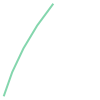

In [ ]:
data["geometry"].iloc[0]

In [ ]:
m = folium.Map(location=[40.7831, -73.9712], zoom_start=12)
folium.GeoJson(small_data["geometry"]).add_to(m)
folium.GeoJson(small_data["geometry"].buffer(0.00015)).add_to(m)
m

<ipython-input-33-414533c05d7e>:3: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  folium.GeoJson(small_data["geometry"].buffer(0.00015)).add_to(m)


In [ ]:
accidents = gpd.GeoDataFrame({'geometry': [Point(-74.0179, 40.7062), Point(-74.0179, 40.7062)]},crs="EPSG:4326")
small_data.buffer(0.0002).contains(Point(-74.0179, 40.7062), align=False)

<ipython-input-28-8e149896cdde>:2: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  small_data.buffer(0.0002).contains(Point(-74.0179, 40.7062), align=False)


0     True
1    False
2    False
3    False
4    False
5    False
6    False
7    False
8     True
9     True
dtype: bool

In [ ]:
small_data["geometry"].iloc[1:2]

1    MULTILINESTRING ((-74.01757 40.70684, -74.0171...
Name: geometry, dtype: geometry

In [ ]:
(np.sum(collisions_df_not_na["NUMBER OF PERSONS KILLED"]>0)/collisions_df_not_na.shape[0])*100

0.1336555651647792

In [ ]:
(np.sum(collisions_df_is_na["NUMBER OF PERSONS KILLED"]>0)/collisions_df_is_na.shape[0])*100
# collisions_df_is_na[(collisions_df_is_na["ON STREET NAME"].notna()) & (collisions_df_is_na["BOROUGH"].notna())]

0.1587238601642792

In [ ]:
(np.sum(collisions_df_not_na["NUMBER OF PERSONS INJURED"]>0)/collisions_df_not_na.shape[0])*100

22.142214990616765

In [ ]:
(np.sum(collisions_df_is_na["NUMBER OF PERSONS INJURED"]>0)/collisions_df_is_na.shape[0])*100

20.29945901617661

In [ ]:
geolocator = Nominatim(user_agent="zigi")

geocode = partial(geolocator.geocode, language="en")
location = geocode("WHITESTONE EXPRESSWAY, NYC, New York")
print(location)
lon = location.longitude
lng = location.latitude

# 5 AVENUE	East 60

Whitestone Expressway, Malba, Queens County, New York, 11357, United States


In [ ]:
api_key = "3b0e4e0f500e4af19d83a6b97dc14f61"
geocoder = opencage.geocoder.OpenCageGeocode(api_key)

# Define the intersection you want to geocode
intersection = "WHITESTONE EXPRESSWAY	and 20 AVENUE, New York County, New York, USA"

# Geocode the intersection and get the latitude and longitude
result = geocoder.geocode(intersection)
lat = result[0]['geometry']['lat']
lng = result[0]['geometry']['lng']

# Print the latitude and longitude
print(f"Latitude: {lat}")
print(f"Longitude: {lng}")

Latitude: 40.701875
Longitude: -74.010673


In [ ]:
m = folium.Map(location=[40.7831, -73.9712], zoom_start=12)
folium.GeoJson(Point(lng, lat)).add_to(m)
m

In [ ]:
# df_na_loc = df[(df["LONGITUDE"].isna() | df["LATITUDE"].isna())&(df["ON STREET NAME"].notna() & df["CROSS STREET NAME"].notna())]
df_na_loc["MONTH"] = pd.to_datetime(df_na_loc["CRASH DATE"]).dt.month
df_na_loc.groupby(["MONTH"]).count()
# df_na_loc.groupby(["YEAR", "MONTH"]).count()

<ipython-input-78-0031d01e84fe>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_na_loc["MONTH"] = pd.to_datetime(df_na_loc["CRASH DATE"]).dt.month


,CRASH DATE,CRASH TIME,BOROUGH,ZIP CODE,LATITUDE,LONGITUDE,LOCATION,ON STREET NAME,CROSS STREET NAME,OFF STREET NAME,...,CONTRIBUTING FACTOR VEHICLE 4,CONTRIBUTING FACTOR VEHICLE 5,COLLISION_ID,VEHICLE TYPE CODE 1,VEHICLE TYPE CODE 2,VEHICLE TYPE CODE 3,VEHICLE TYPE CODE 4,VEHICLE TYPE CODE 5,DATE,YEAR
MONTH,,,,,,,,,,,,,,,,,,,,,
1,9869,9869,1078,1078,0,0,0,9869,9869,0,...,116,31,9869,9841,8483,569,117,31,9869,9869
2,10426,10426,1123,1123,0,0,0,10426,10426,0,...,99,23,10426,10409,9078,488,97,23,10426,10426
3,13484,13484,4920,4919,0,0,0,13484,13484,4,...,137,34,13484,13316,11275,688,137,30,13484,13484
4,17233,17233,9257,9254,0,0,0,17233,17233,3,...,196,42,17233,16965,14326,902,182,38,17233,17233
5,11272,11272,2988,2987,0,0,0,11272,11272,2,...,129,35,11272,11206,9869,663,125,33,11272,11272
6,9726,9726,1536,1536,0,0,0,9726,9726,1,...,120,31,9726,9676,8552,530,114,30,9726,9726
7,11061,11061,1417,1417,0,0,0,11061,11061,0,...,134,26,11061,11029,9826,650,133,24,11061,11061
8,10726,10726,1449,1448,0,0,0,10726,10726,0,...,84,15,10726,10689,9474,545,78,15,10726,10726
9,10837,10837,1548,1548,0,0,0,10837,10837,0,...,121,34,10837,10794,9496,591,119,33,10837,10837


In [ ]:
m = folium.Map(location=[40.7831, -73.9712], zoom_start=12)
for i in range(small_data.shape[0]):
  col1 = Point(small_data[["LONGITUDE","LATITUDE"]].iloc[i:i+1,])
  folium.GeoJson(col1).add_to(m)
  folium.GeoJson(small_data["STREET"].iloc[i,]).add_to(m)
m